# Usage of Deeplab + LIP model and extracion of ROI 

In this notebook, the segmentation of the desired images are done, followed by a contour processing to reduce the impact of noise and segmentation errors.

## Dependencies

In [1]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib
import cv2
import glob

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from IPython.display import display
from google.colab.patches import cv2_imshow
import pandas as pd

%tensorflow_version 1.x
import tensorflow as tf

import ipywidgets as widgets
import math

TensorFlow 1.x selected.


## Path definitions - change to your own

In [2]:
MODEL_INFER_GRAPH = "/content/drive/MyDrive/TFM/exported_model_8k/frozen_inference_graph.pb"
VIS_IMAGES = "/content/drive/MyDrive/TFM/BibNumberTestPeopleImg"
EXPORT_CROP = "/content/drive/MyDrive/TFM/BibNumberTestSegResultsBase"

USING_ANNOTATIONS = True
VIS_IMAGES_ANNOTATIONS = "/content/drive/MyDrive/TFM/BibNumberTestPeopleImg/annotateTest.csv" 
ANNOTATION_COLUMNS = ["filename", "x_min", "y_min", "x_max", "y_max", "class"]
NEW_ANNOTATIONS = pd.DataFrame(columns=ANNOTATION_COLUMNS)

## Mount Google Drive storage
In case you need it

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Deeplab model class to perform the segmentation and visualize it

In [4]:
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, frozen_graph):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    f = open(frozen_graph, "rb")
    graph_df = tf.GraphDef.FromString(f.read())

    if not os.path.isfile(frozen_graph) or graph_df is None:
      raise RuntimeError('Cannot find inference graph.')

    with self.graph.as_default():
      tf.import_graph_def(graph_df, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(image)]}
    )
    
    seg_map = unify_labels(batch_seg_map[0])
    

    return image, seg_map


def unify_labels(seg_map):
  """Unifies certains labels from LIP in the segmentation map.

    Args:
      seg_map: Segmentation map from DeeplabModel run(sel, image) method

    Returns:
      seg_map: Segmentation map with unified labels.
    """

  # Dress and Coat will be appear as UpperClothes
  seg_map = np.where(seg_map==6, 5, seg_map) # UpperClothes == Dress
  seg_map = np.where(seg_map==7, 5, seg_map) # UpperClothes == Coat
  
  # Fuse left and right arm in a single instance
  seg_map = np.where(seg_map==14, 15, seg_map) 

  # Fuse left and right leg in a single instance
  seg_map = np.where(seg_map==16, 17, seg_map)

  # Fuse left and right shoe in a single instance
  seg_map = np.where(seg_map==18, 19, seg_map) 

  return seg_map

def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map, body_color, pants_color):
  """Visualizes input image, segmentation map, segmentation overlay, blob overlay and biggest blob overlay view."""
  plt.figure(figsize=(30, 5))
  grid_spec = gridspec.GridSpec(1, 6, width_ratios=[6, 6, 6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  plt.subplot(grid_spec[3])
  blob_image, biggest_blobs, _ = get_contours_with_colors(seg_image, body_color, pants_color)
  plt.imshow(image)
  plt.imshow(blob_image, alpha=0.7)
  plt.axis('off')
  plt.title('blob overlay')

  plt.subplot(grid_spec[4])
  plt.imshow(image)
  plt.imshow(biggest_blobs, alpha=0.7)
  plt.axis('off')
  plt.title('biggest blob overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[5])
  plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'Background', 'Hat', 'Hair', 'Glove', 'Sunglasses', 'UpperClothes', 'Dress', 'Coat',
    'Socks', 'Pants', 'Jumpsuits', 'Scarf', 'Skirt', 'Face', 'Left-Arm', 'Arm',
    'Left-leg', 'Leg', 'Left-shoe', 'Shoe'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

MODEL = DeepLabModel(MODEL_INFER_GRAPH)

In [5]:
BODY_COLOR = FULL_COLOR_MAP[5]
PANTS_COLOR = FULL_COLOR_MAP[9]

## Functions definitions

In [6]:
def save_annotation(original_annotations, object_detection):
  global NEW_ANNOTATIONS

  if NEW_ANNOTATIONS is not None and original_annotations is not None:
    df_ann = pd.read_csv(original_annotations, header=None)
    df_ann.columns = ["filename", "x_min", "y_min", "x_max", "y_max", "class"]
    df_ann = df_ann[df_ann['filename'].str.endswith(os.path.basename(object_detection['filename']))]

    for index, row in df_ann.iterrows():
      x_min = row['x_min'] - object_detection['x']
      y_min = row['y_min'] - object_detection['y']
      x_max = (object_detection['x2'] - object_detection['x']) - (object_detection['x2'] -  row['x_max'])
      y_max = (object_detection['y2'] - object_detection['y']) - (object_detection['y2'] -  row['y_max'])

      if (x_min >= 0 and y_min >= 0 and x_max >= 0 and y_max >= 0) and (x_min <= (object_detection['x2'] - object_detection['x']) and y_min <= (object_detection['y2'] - object_detection['y']) and x_max <= (object_detection['x2'] - object_detection['x']) and y_max <= (object_detection['y2'] - object_detection['y'])):
        NEW_ANNOTATIONS = NEW_ANNOTATIONS.append({
            'filename': object_detection['filename'],
            'x_min': x_min,
            'y_min': y_min,
            'x_max': x_max,
            'y_max': y_max,
            'class': row['class']
        }, ignore_index=True)
        print(NEW_ANNOTATIONS.tail().iloc[:, 1:5])
      else:
        print('Not valid annotation placing')

In [7]:
def biggest_contours(contours_body, contours_pants):
  """Finds the contours with highest area with body and pants label.

    Args:
      contours_body: Contours found labeled as body
      contours_pants: Contours found labeled as pants

    Returns:
      biggest_body: Index of the highest-area body contour
      biggest_pants: Index of the highest-area pants contour
  """  
  pants_centroid = None
  biggest_pants = 0

  for index, pants in enumerate(contours_pants):
    if cv2.contourArea(pants) > cv2.contourArea(contours_pants[biggest_pants]):
      M = cv2.moments(pants)
      cx = int(M["m10"] / M["m00"]) if int(M["m00"]) > 0 else 0
      cy = int(M["m01"] / M["m00"]) if int(M["m00"]) > 0 else 0
      pants_centroid = (cx, cy)
      biggest_pants = index

  biggest_body = None

  for index, body in enumerate(contours_body):
    M = cv2.moments(body)

    cx = int(M["m10"] / M["m00"]) if int(M["m00"]) > 0 else 0
    cy = int(M["m01"] / M["m00"]) if int(M["m00"]) > 0 else 0
    body_centroid = (cx, cy)

    if body_centroid[0] == 0 and body_centroid[1] == 0:
      continue

    if pants_centroid != None and body_centroid[1] < pants_centroid[1]:
      if biggest_body == None or cv2.contourArea(body) > cv2.contourArea(contours_body[biggest_body]):
        biggest_body = index
    
    if pants_centroid == None:
       if biggest_body == None or cv2.contourArea(body) > cv2.contourArea(contours_body[biggest_body]):
        biggest_body = index

  return biggest_body, biggest_pants

In [24]:
def crop_roi(im, seg_map, body_color, pants_color):
  """Crops the image to the ROI (body + pants).

    Args:
      im: Image to crop
      seg_map: Segmentation map of the image to crop
      body_color: Body color in the segmentation map
      pants_color: Pants color in the segmentation map

    Returns:
      out: Cropped image within the ROI
  """
  img = cv2.imread(im)

  seg_image = label_to_color_image(seg_map).astype(np.uint8)

  _, _, contours = get_contours_with_colors(seg_image, body_color, pants_color)
  i_body, i_pants = biggest_contours(contours[0], contours[1])

  out = img

  height, width = img.shape[:2]

  if contours[0] !=  None and len(contours) > 0 and len(contours[0]) > 0 and i_body != None:
    xb, yb, wb, hb = cv2.boundingRect(contours[0][i_body])

    # If no pants are found, upper bound should be calculated with the body
    xp = xb
    yp = yb
    wp = wb
    hp = hb

    if contours[1] !=  None and len(contours) > 1 and len(contours[1]) > 1:
      xp, yp, wp, hp = cv2.boundingRect(contours[1][i_pants])

    mask = np.zeros_like(img)

    cv2.drawContours(mask, contours[0], i_body, (255,255,255), -1)
    if contours[1] !=  None and len(contours) > 1 and len(contours[1]) > 1:
      cv2.drawContours(mask, contours[1], i_pants, (255,255,255), -1)

    out = np.zeros_like(img)

    out[mask == 255] = img[mask == 255]
    out[mask == 0] = img[mask == 0]

    (top_y, top_x) = (yb, min(xb, xp))
    (bottom_y, bottom_x) = (yp + hp, max(xb + wb, xp + wp))

    # Check if x-y coordinates are ok - else use the whole image 
    # semantic segmentation went wrong

    if top_y < bottom_y and top_x < bottom_x: 
      out = out[top_y:bottom_y+1, top_x:bottom_x+1]

      if USING_ANNOTATIONS:
        save_annotation(VIS_IMAGES_ANNOTATIONS, {
            'filename': im, 
            'x': top_x, 
            'y': top_y, 
            'x2': bottom_x, 
            'y2': bottom_y
            })
    else:
      print('Segmentation went wrong. Using whole image')
      out = img

      if USING_ANNOTATIONS:
        print('Body segmentation not found')
        save_annotation(VIS_IMAGES_ANNOTATIONS, {
            'filename': im, 
            'x': 0, 
            'y': 0, 
            'x2': width, 
            'y2': height
            }) 
  else:
    # Upper body segmentation not found: Save the annotation like the original
    if USING_ANNOTATIONS:
      print('Body segmentation not found')
      save_annotation(VIS_IMAGES_ANNOTATIONS, {
          'filename': im, 
          'x': 0, 
          'y': 0, 
          'x2': width, 
          'y2': height
          }) 

  return cv2.cvtColor(out, cv2.COLOR_BGR2RGB)

In [9]:
def crop_roi_bottom(im, seg_map, body_color):
  """Crops the image to the ROI (body + bottom-image).

    Args:
      im: Image to crop
      seg_map: Segmentation map of the image to crop
      body_color: Body color in the segmentation map

    Returns:
      out: Cropped image within the ROI
  """
  img = cv2.imread(im)

  height, width = img.shape[:2]

  seg_image = label_to_color_image(seg_map).astype(np.uint8)

  _, _, contours = get_contours_with_colors(seg_image, body_color, None)
  i_body, _ = biggest_contours(contours[0], [])

  out = img

  height, width = img.shape[:2]

  if contours[0] !=  None and len(contours) > 0 and len(contours[0]) > 0 and i_body != None:
    xb, yb, wb, hb = cv2.boundingRect(contours[0][i_body])

    mask = np.zeros_like(img)

    cv2.drawContours(mask, contours[0], i_body, (255,255,255), -1)
    out = np.zeros_like(img)

    out[mask == 255] = img[mask == 255]
    out[mask == 0] = img[mask == 0]

    (top_y, top_x) = (yb, xb)
    (bottom_y, bottom_x) = (height, width)
    out = out[top_y:bottom_y+1, top_x:bottom_x+1]

    if USING_ANNOTATIONS:
      save_annotation(VIS_IMAGES_ANNOTATIONS, {
          'filename': im, 
          'x': top_x, 
          'y': top_y, 
          'x2': bottom_x, 
          'y2': bottom_y
          }) 
  else:
    # Upper body segmentation not found: Save the annotation like the original
    if USING_ANNOTATIONS:
      print('Body segmentation not found')
      save_annotation(VIS_IMAGES_ANNOTATIONS, {
          'filename': im, 
          'x': 0, 
          'y': 0, 
          'x2': width, 
          'y2': height
          }) 

  return cv2.cvtColor(out, cv2.COLOR_BGR2RGB)

In [10]:
def get_contours_with_colors(seg_map, body_color, pants_color):
  """Get contours of the ROI (body + pants).

    Args:
      seg_map: Segmentation map of the image
      body_color: Body color in the segmentation map
      pants_color: Pants color in the segmentation map

    Returns:
      seg_map: Segmentation map with the contours drawn
      seg_map_biggest_blobs: Segmentation map with the highest-area contours drawn
      [contours_body, contours_pants]: List of the contours found
  """ 
  seg_map_body = np.copy(seg_map)
  seg_map_pants = np.copy(seg_map)
  seg_map_biggest_blobs = np.copy(seg_map)

  seg_map_body[seg_map_body == body_color] = 255
  seg_map_pants[seg_map_pants == pants_color] = 255

  imgray_body = cv2.cvtColor(seg_map_body, cv2.COLOR_BGR2GRAY)
  imgray_pants = cv2.cvtColor(seg_map_pants, cv2.COLOR_BGR2GRAY)

  _, thresh_body = cv2.threshold(imgray_body, 254, 255, cv2.THRESH_BINARY)
  _, thresh_pants = cv2.threshold(imgray_pants, 254, 255, cv2.THRESH_BINARY)

  contours_body, _ = cv2.findContours(thresh_body, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contours_pants, _ = cv2.findContours(thresh_pants, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  biggest_body, biggest_pants = biggest_contours(contours_body, contours_pants)

  cv2.drawContours(seg_map, contours_body, -1, (0,255,0), 3)
  cv2.drawContours(seg_map, contours_pants, -1, (255,255,0), 3)

  if biggest_body != None:
    cv2.drawContours(seg_map_biggest_blobs, contours_body, biggest_body, (0,255,0), 3)
  if biggest_pants != None:
    cv2.drawContours(seg_map_biggest_blobs, contours_pants, biggest_pants, (255,255,0), 3)

  return seg_map, seg_map_biggest_blobs, [contours_body, contours_pants]

## Visualize results

In [18]:
image_list_siani = os.listdir(VIS_IMAGES)
image_picker_siani = widgets.Dropdown(options=image_list_siani, value=image_list_siani[0], disabled=False)
image_picker_siani

Dropdown(options=('0_bib_number_0005.jpg', '1_bib_number_0005.jpg', '2_bib_number_0005.jpg', '3_bib_number_000…

### Segmentation and blobs

In [11]:
def run_visualization_siani(file):
  """Inferences DeepLab model and visualizes result."""
  try:
    original_im = Image.open(os.path.join(VIS_IMAGES, file))
  except IOError:
    print('Cannot retrieve image. Please check file: ' + os.path.join(VIS_IMAGES, file))
    return

  print('running deeplab on image %s...' % file)
  resized_im, seg_map = MODEL.run(original_im)

  vis_segmentation(resized_im, seg_map, BODY_COLOR, PANTS_COLOR)

running deeplab on image 98_bib_number_0186.jpg...


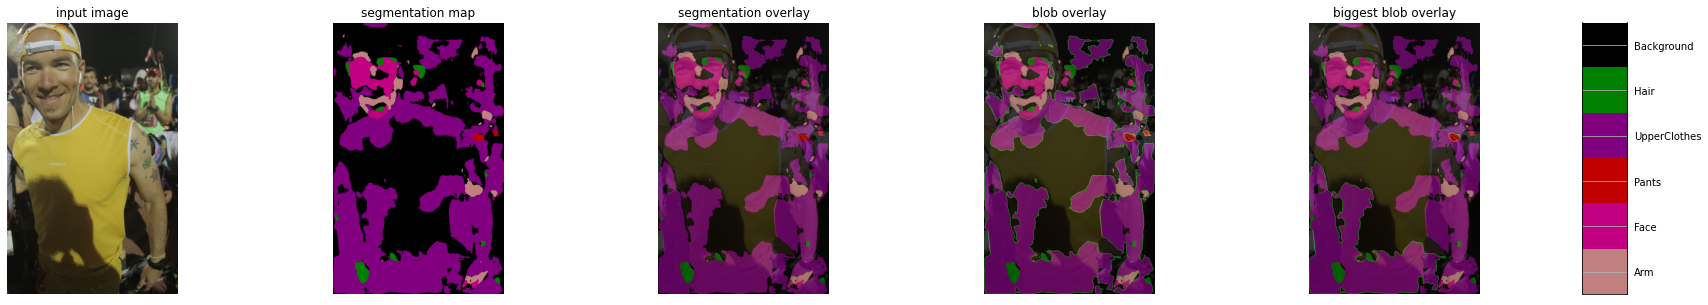

In [19]:
run_visualization_siani(image_picker_siani.value)

### Cropping

In [12]:
def run_crop_siani(file):
  """Inferences DeepLab model and visualizes result."""
  try:
    original_im = Image.open(os.path.join(VIS_IMAGES, file))
  except IOError:
    print('Cannot retrieve image. Please check file: ' + os.path.join(VIS_IMAGES, file))
    return

  print('running deeplab on image %s...' % file)
  resized_im, seg_map = MODEL.run(original_im)

  return resized_im, crop_roi(os.path.join(VIS_IMAGES, file), seg_map, BODY_COLOR, PANTS_COLOR)

In [13]:
def run_crop_bottom(file):
  """Inferences DeepLab model and visualizes result."""
  try:
    original_im = Image.open(os.path.join(VIS_IMAGES, file))
  except IOError:
    print('Cannot retrieve image. Please check file: ' + os.path.join(VIS_IMAGES, file))
    return

  print('running deeplab on image %s...' % file)
  resized_im, seg_map = MODEL.run(original_im)

  return resized_im, crop_roi_bottom(os.path.join(VIS_IMAGES, file), seg_map, BODY_COLOR)

In [22]:
img, crop = run_crop_siani(image_picker_siani.value)

print(f'\nOriginal image: ({img.size[1]}, {img.size[0]})')
print(f'Cropped image: {crop.shape}\n')

fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1,2,1)
plt.imshow(img)
plt.axis('off')
fig.add_subplot(1,2,2)
plt.imshow(Image.fromarray(crop))
plt.axis('off')

running deeplab on image 98_bib_number_0186.jpg...
1572 3 1355 1713
[]
Not valid annotation placing


error: ignored

## Crop and save all images in a folder

In [ ]:
%mkdir {EXPORT_CROP}

mkdir: cannot create directory ‘/content/drive/MyDrive/TFM/BibNumberTestSegResultsBase’: File exists


### Format 1: A single directory with all the images

In [ ]:
skip_existing_imgs = True
total = len(glob.glob1(VIS_IMAGES, "*.jpg"))
count = 0

for filename in glob.glob(VIS_IMAGES + '/*.jpg'):
  if skip_existing_imgs and os.path.exists(os.path.join(EXPORT_CROP, os.path.basename(filename))):
    print(f'Skipping image {os.path.join(EXPORT_CROP, os.path.basename(filename))}')
  else:
    _, crop = run_crop_siani(os.path.join(VIS_IMAGES, filename))
    cv2.imwrite(os.path.join(EXPORT_CROP, os.path.basename(filename)), cv2.cvtColor(crop, cv2.COLOR_RGB2BGR))
    if USING_ANNOTATIONS and NEW_ANNOTATIONS is not None:
      NEW_ANNOTATIONS.to_csv(os.path.join(EXPORT_CROP, 'annotateTest.csv'), header=None, index=False)
  count = count + 1
  print(f'Image {count}/{total}')

Skipping image /content/drive/MyDrive/TFM/BibNumberTestSegResultsBase/0_bib_number_0005.jpg
Image 1/824
Skipping image /content/drive/MyDrive/TFM/BibNumberTestSegResultsBase/1_bib_number_0005.jpg
Image 2/824
Skipping image /content/drive/MyDrive/TFM/BibNumberTestSegResultsBase/2_bib_number_0005.jpg
Image 3/824
Skipping image /content/drive/MyDrive/TFM/BibNumberTestSegResultsBase/3_bib_number_0005.jpg
Image 4/824
Skipping image /content/drive/MyDrive/TFM/BibNumberTestSegResultsBase/4_bib_number_0008.jpg
Image 5/824
Skipping image /content/drive/MyDrive/TFM/BibNumberTestSegResultsBase/5_bib_number_0008.jpg
Image 6/824
Skipping image /content/drive/MyDrive/TFM/BibNumberTestSegResultsBase/6_bib_number_0008.jpg
Image 7/824
Skipping image /content/drive/MyDrive/TFM/BibNumberTestSegResultsBase/7_bib_number_0008.jpg
Image 8/824
Skipping image /content/drive/MyDrive/TFM/BibNumberTestSegResultsBase/8_bib_number_0008.jpg
Image 9/824
Skipping image /content/drive/MyDrive/TFM/BibNumberTestSegResult

### Format 1.1: A single directory with all the images - Ignore images with bad annotation crop

In [ ]:
total = len(glob.glob1(VIS_IMAGES, "*.jpg"))
count = 0
annotations_count = 0

for filename in glob.glob(VIS_IMAGES + '/*.jpg'):
  if USING_ANNOTATIONS and NEW_ANNOTATIONS is not None:
    annotations_count = len(NEW_ANNOTATIONS.index)

  _, crop = run_crop_siani(os.path.join(VIS_IMAGES, filename))

  if USING_ANNOTATIONS and NEW_ANNOTATIONS is not None:
    df_ann = pd.read_csv(VIS_IMAGES_ANNOTATIONS, header=None)
    df_ann.columns = ["filename", "x_min", "y_min", "x_max", "y_max", "class"]
    df_ann = df_ann[df_ann['filename'].str.endswith(os.path.basename(filename))]

    if len(df_ann.index) == 0 or (len(df_ann.index) > 0 and len(NEW_ANNOTATIONS) > annotations_count):
      cv2.imwrite(os.path.join(EXPORT_CROP, os.path.basename(filename)), cv2.cvtColor(crop, cv2.COLOR_RGB2BGR))
  else:
    cv2.imwrite(os.path.join(EXPORT_CROP, os.path.basename(filename)), cv2.cvtColor(crop, cv2.COLOR_RGB2BGR))

  if USING_ANNOTATIONS and NEW_ANNOTATIONS is not None:
    NEW_ANNOTATIONS.to_csv(os.path.join(EXPORT_CROP, 'annotateTest.csv'), header=None, index=False)
    
  count = count + 1
  print(f'Image {count}/{total}')

### Format 1.2: A single directory with all the images - Upper body to bottom image crop

In [ ]:
total = len(glob.glob1(VIS_IMAGES, "*.jpg"))
count = 0
annotations_count = 0

for filename in glob.glob(VIS_IMAGES + '/*.jpg'):
  if USING_ANNOTATIONS and NEW_ANNOTATIONS is not None:
    annotations_count = len(NEW_ANNOTATIONS.index)

  _, crop = run_crop_bottom(os.path.join(VIS_IMAGES, filename))

  if USING_ANNOTATIONS and NEW_ANNOTATIONS is not None:
    df_ann = pd.read_csv(VIS_IMAGES_ANNOTATIONS, header=None)
    df_ann.columns = ["filename", "x_min", "y_min", "x_max", "y_max", "class"]
    df_ann = df_ann[df_ann['filename'].str.endswith(os.path.basename(filename))]

    if len(df_ann.index) == 0 or (len(df_ann.index) > 0 and len(NEW_ANNOTATIONS) > annotations_count):
      cv2.imwrite(os.path.join(EXPORT_CROP, os.path.basename(filename)), cv2.cvtColor(crop, cv2.COLOR_RGB2BGR))
  else:
    cv2.imwrite(os.path.join(EXPORT_CROP, os.path.basename(filename)), cv2.cvtColor(crop, cv2.COLOR_RGB2BGR))

  if USING_ANNOTATIONS and NEW_ANNOTATIONS is not None:
    NEW_ANNOTATIONS.to_csv(os.path.join(EXPORT_CROP, 'annotateTest.csv'), header=None, index=False)

  count = count + 1
  print(f'Image {count}/{total}')

Se han truncado las últimas 5000 líneas del flujo de salida.
Body segmentation not found
Image 324/1498
running deeplab on image /content/drive/MyDrive/TFM/CROP3/823_Arucas_frame_01_35_41_000.jpg...
Image 325/1498
running deeplab on image /content/drive/MyDrive/TFM/CROP3/824_Arucas_frame_01_29_16_000.jpg...
Image 326/1498
running deeplab on image /content/drive/MyDrive/TFM/CROP3/825_Arucas_frame_01_29_16_000.jpg...
    x_min y_min x_max y_max
107    49   128   125   182
108   119   254   233   331
109    49    87    82   115
110    81   127   130   166
111    89   256   193   349
Image 327/1498
running deeplab on image /content/drive/MyDrive/TFM/CROP3/826_Arucas_frame_01_29_16_000.jpg...
Image 328/1498
running deeplab on image /content/drive/MyDrive/TFM/CROP3/827_Arucas_frame_01_29_16_000.jpg...
Image 329/1498
running deeplab on image /content/drive/MyDrive/TFM/CROP3/828_Arucas_frame_01_29_16_000.jpg...
Image 330/1498
running deeplab on image /content/drive/MyDrive/TFM/CROP3/829_Arucas

### Format 2: A directory with multiple directories with images in each of them

In [ ]:
count = 0

for root, subdirs, files in os.walk(VIS_IMAGES):
  if len(subdirs) == 0:
    dir = os.path.join(EXPORT_CROP, os.path.basename(root))
    try:
      os.mkdir(dir)
      print(f'[+] Directory {dir} created') 
    except FileExistsError:
      pass

    for file in files:
      file_path = os.path.join(os.path.join(VIS_IMAGES, os.path.basename(root)), file)
      _, crop = run_crop_siani(file_path)
      cv2.imwrite(os.path.join(dir, file), cv2.cvtColor(crop, cv2.COLOR_RGB2BGR))
      count = count + 1
      print(f'Image {count}')